In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement
from pyfoomb import ParameterMapper
from pyfoomb.utils import Helpers

Could not find GLIMDA.


Current package version of pyfoomb: 2.17.0


In [2]:
import matplotlib
from matplotlib import pyplot
import numpy
import pandas
import time

# Set seed of random number generator for reproducibility
numpy.random.seed(123)

# Parallelized parameter estimation

This notebook demonstrates the basic use and evaluation of two `Caretaker` methods that parallelize the parameter estimation process with global optimization algorithms. This functionality is provided by the super cool `pygmo` package, see https://esa.github.io/pygmo2/.

### Some helper functions for this notebook

In [3]:
# Creates a noisy dataset, based on a forward simulation
def noisy_samples(simulations, samples=5, rel_err=0.05, abs_err=0.05, repetitions=3, with_errors=True):
    artifical_data = []
    
    # get joint time points
    t_all = Helpers.get_unique_timepoints(simulations)

    # iterate over simulations
    for simulation in simulations:
        
        _name = simulation.name
        _replicate_id = simulation.replicate_id
        _t_samples = numpy.random.choice(simulation.timepoints, size=samples, replace=False)
        _sample_idxs = numpy.in1d(simulation.timepoints, _t_samples)
        _timepoints = simulation.timepoints[_sample_idxs]
        _values = simulation.values[_sample_idxs]
        
        # generate random samples
        _rnd_values = [
            numpy.random.normal(loc=_values, scale=abs(_values*rel_err+abs_err)) 
            for _ in range(repetitions)
        ]
        
        # create new Measurement object
        _measurement = Measurement(
            name=_name, 
            replicate_id=_replicate_id,
            timepoints=_timepoints, 
            values=numpy.mean(_rnd_values, axis=0),
            errors=numpy.std(_rnd_values, ddof=1, axis=0) if with_errors else None,
        )
        artifical_data.append(_measurement)
        
    return artifical_data


def make_experiment(caretaker:Caretaker, tfinal:float, samples:int=3, show:bool=True):
    
    simulation = caretaker.simulate(t=tfinal)
    data = noisy_samples(caretaker.simulate(t=numpy.arange(tfinal*4)/4), samples=samples)
    if show:
        _ncols = len(set([_item.name for _item in simulation]))
        _ = Visualization.show_kinetic_data(simulation, ncols=_ncols)
        _ncols = len(set([_item.name for _item in data]))
        _ = Visualization.show_kinetic_data(data, ncols=_ncols)

    return data, simulation
    

# Example 1: A bioprocess model


First, the bioprocess model is defined. This model is also used to generate some noisy artifical data to demonstrate the parameter estimation process.

In [4]:
# Defines the model class
class GrowthCoupledProduction(BioprocessModel):
        
    def specific_growth_rate_mu(self, t, y):
        P, S, X = y
        kS = self.model_parameters['kS']
        mu_max = self.model_parameters['mu_max']
        mu = mu_max * S / (kS + S)
        return mu
    
    def specific_production_rate_qP(self, t, y):
        P, S, X = y
        YPX = self.model_parameters['YPX']
        mu = self.specific_growth_rate_mu(t, y)
        qP = YPX * mu
        return qP
    
    def specific_substrate_consumption_rate_qS(self, t, y):
        P, S, X = y
        YXS = self.model_parameters['YXS']
        YPS = self.model_parameters['YPS']
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = 1/YXS * mu + 1/YPS * qP
        return qS
    
    def rhs(self, t, y):
        
        # Unpacks the state vector. The states are alphabetically ordered.
        P, S, X = y

        # Calculate specific rates
        mu = self.specific_growth_rate_mu(t, y)
        qP = self.specific_production_rate_qP(t, y)
        qS = self.specific_substrate_consumption_rate_qS(t, y)

        # Calculate state derivatives
        dXdt = mu * X
        dSdt = -qS * X
        dPdt = qP * X
        
        return [dPdt, dSdt, dXdt]

    
model_parameters = {
    'kS' : 0.05,
    'mu_max' : 0.4,
    'YXS' : 0.6,
    'YPS' : 0.4,
    'YPX' : 0.2,
}     

initial_values = {
    'S0' : 20.0,
    'X0' : 0.01,
    'P0' : 0.0,
}

# Instantiates are caretaker with two replicate_ids
caretaker = Caretaker(
    bioprocess_model_class=GrowthCoupledProduction, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

# Save for later comparison
_pars_for_comp = caretaker._get_all_parameters()

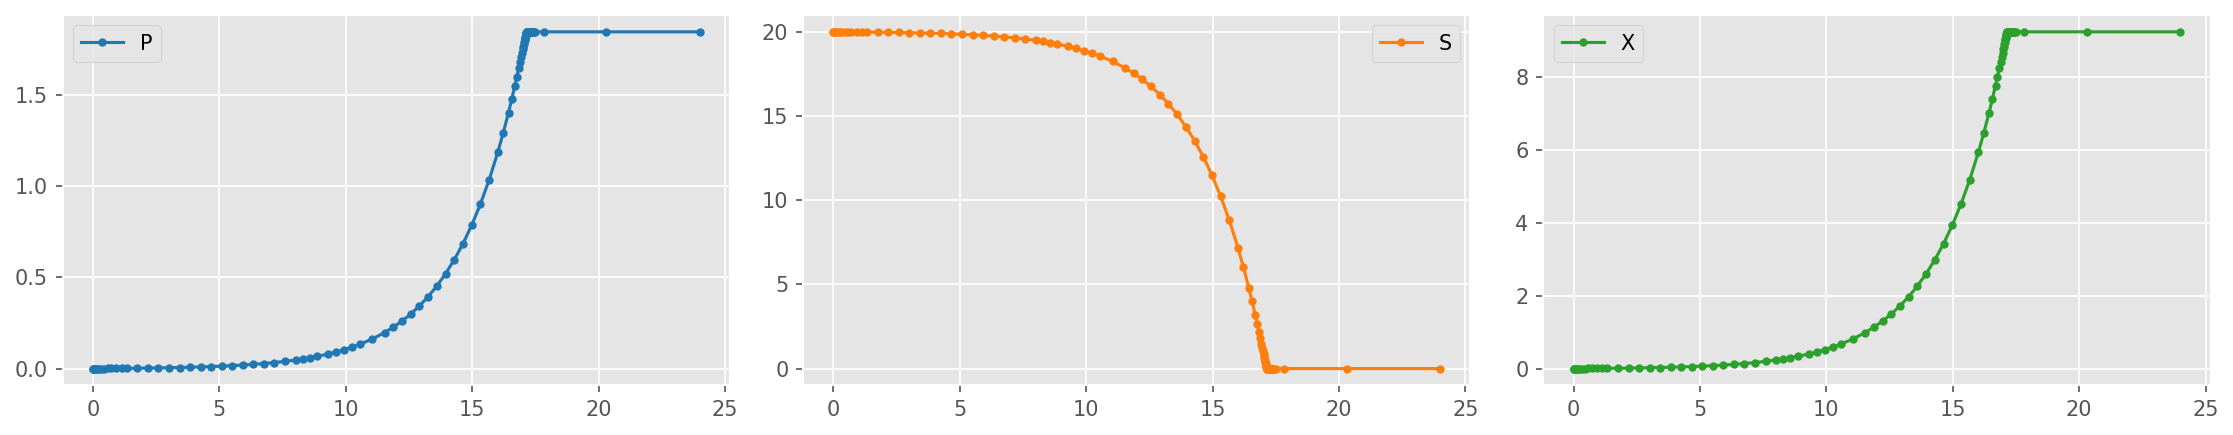

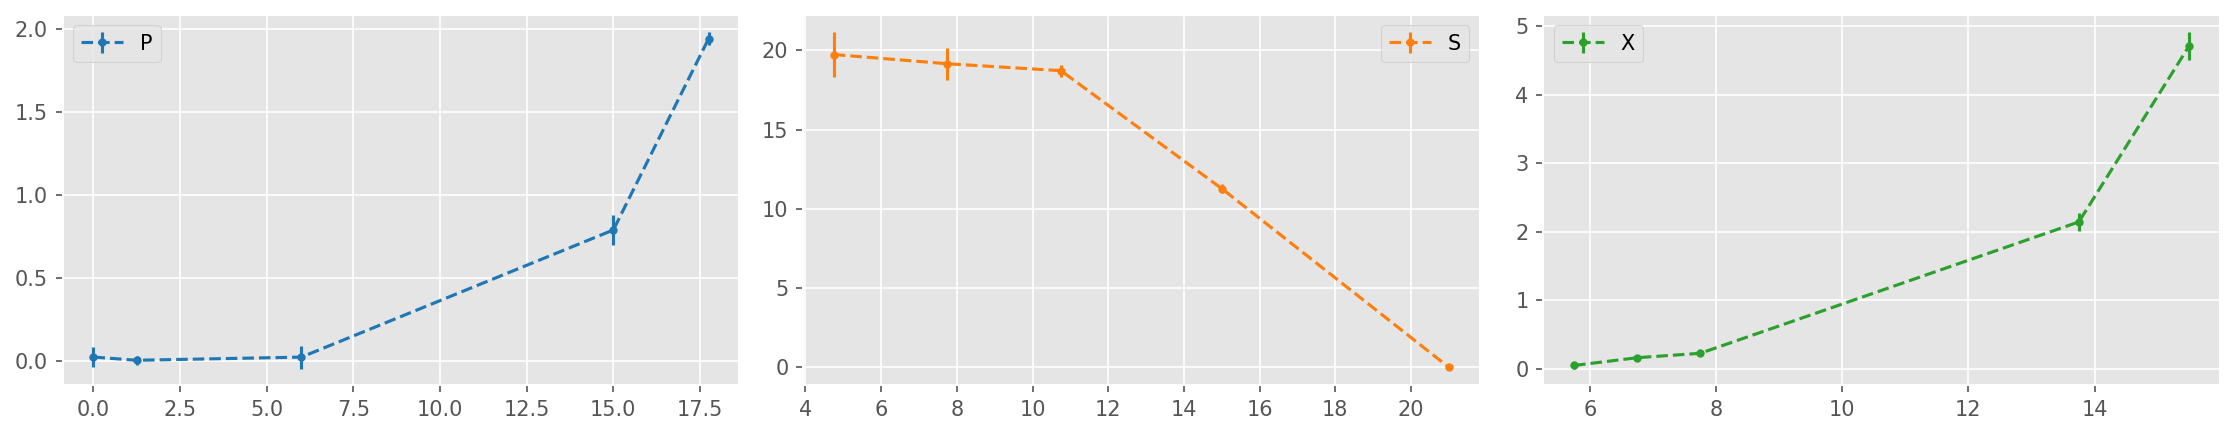

In [5]:
# Generates noisy artificial data from the simulation
data, simulation = make_experiment(caretaker, tfinal=24, samples=5)

In [6]:
# Defines the unknowns to be estimated, as well as corresponding bounds
unknowns = [
    'kS', 
    'mu_max', 
    'YXS', 
    'YPS', 
    'YPX',
    'S0',
]

bounds = [
    (0.01, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (0.1, 1),
    (17.5, 22.5),
]

# Compare different optimizers for the model calibration task

The `Caretaker`'s method `estimate_parallel` can use different optimization algorithms, provided by the `pygmo` package (see https://esa.github.io/pygmo2/overview.html#list-of-algorithms), via its `optimizers` keyword argument. Based on own experiences, the following algorithms were found to perform well for parameter estimation in bioprocess ODE models:
1. `de1220`: Self-adaptive Differential Evolution, pagmo/pygmo flavor
2. `de` : Differential Evolution
3. `sade`: Self-adaptive Differential Evolution
4. `ihs` : Improved Harmony Search
5. `compass_search` : Compass Search, a local optimizer
6. `simulated_annealing` : Simulated Annealing, Corona's version
7. `pso` : Particle Swarm Optimization
8. `bee_colony` : Artifical Bee Colony
9. `sga` : Simple Genetic Algorithm
10. `sea` : Simple Evolutionary Algorithm

In the following, these optimizers are compared for the parameter estimation. For each algorithm, its default settings are used. 

In [7]:
def run_estimation(optimizers, max_evos, max_evotime, report_level):
    return caretaker.estimate_parallel(
        unknowns=unknowns,
        bounds=bounds,
        measurements=data, 
        optimizers=optimizers,
        evolutions=max_evos,
        max_evotime_min=max_evotime,
        report_level=report_level,
    )

optimizers = [
    'de1220', 
    'de', 
    'sade', 
    'ihs', 
    'compass_search', 
    'mbh',
    'simulated_annealing', 
    'pso', 
    'bee_colony', 
    'sga', 
    'sea',
]

max_evos = 1000 # To cope with the fact that different optimizers need different runtimes for an evolution
max_evotime = 5 # In min

## Run the comparison.

NOTE: This will require a considerable amount of time. 

In [8]:
results = []
for _optimizers in optimizers:
    print(f'\nRunning estimation job for: {_optimizers}')
    print('##########################################################################')
    _result = run_estimation(_optimizers, max_evos, max_evotime, 1)
    results.append(_result)


Running estimation job for: de1220
##########################################################################
Creating archipelago with 12 islands. May take some time...
Running 1000 evolutions for all 12 islands of the archipelago...

...........................
Reached a stopping criterion after evolution 27:
convergence: True
max_runtime: False
max_evotime: False
max_memory_share: False

Estimated parameters:
kS: 0.01000090734020896
mu_max: 0.39543417470725145
S0: 20.16138820166608
YPS: 0.4847561709921404
YPX: 0.22644134885916098
YXS: 0.5296257907369633

-------------Finished evolution 27-------------
Current best loss: -16.943890920446638
Average loss among the islands: -16.943890 +/- 0.000000 (0.000002 %)

Total runtime was 1.19 min


Running estimation job for: de
##########################################################################
Creating archipelago with 12 islands. May take some time...
Running 1000 evolutions for all 12 islands of the archipelago...

.................

........................................................................................................................
........................................................................................................................
........................................................................................................................
........................................................................................................................
........................................................................................................................
................
Reached a stopping criterion after evolution 736:
convergence: False
max_runtime: False
max_evotime: True
max_memory_share: False

Estimated parameters:
kS: 0.0659872916272647
mu_max: 0.3967341250223997
S0: 20.151916571031094
YPS: 0.19910033699796442
YPX: 0.22594377209875705
YXS: 0.8235179995184997

-------------Finished evolution 736-------------
Current best loss: -16.92559

## Visualize results

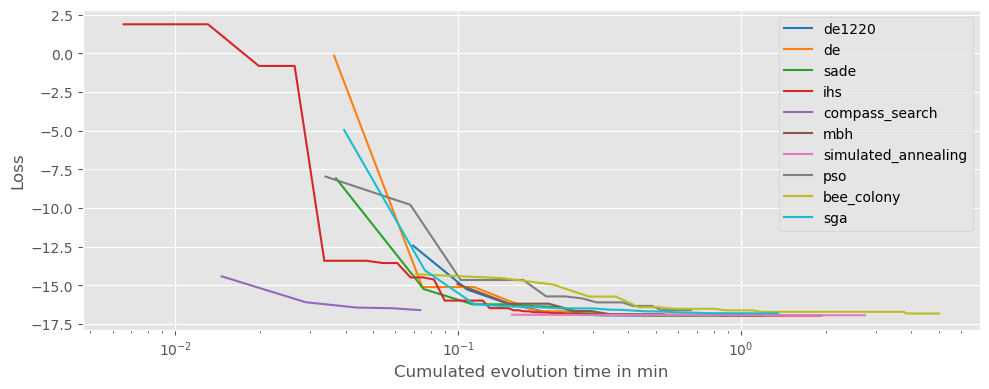

In [9]:
fig, ax = pyplot.subplots(dpi=100, figsize=(10, 4))
for _result, _optimizers, _color in zip(results, optimizers, matplotlib.cm.get_cmap('tab10').colors):
    ax.plot(
        _result[1].evotime_trail, _result[1].best_loss_trail, color=_color, label=_optimizers,
    )
ax.set_xlabel('Cumulated evolution time in min', size=12)
ax.set_xscale('log')
ax.set_ylabel('Loss', size=12)
ax.legend()
fig.tight_layout()

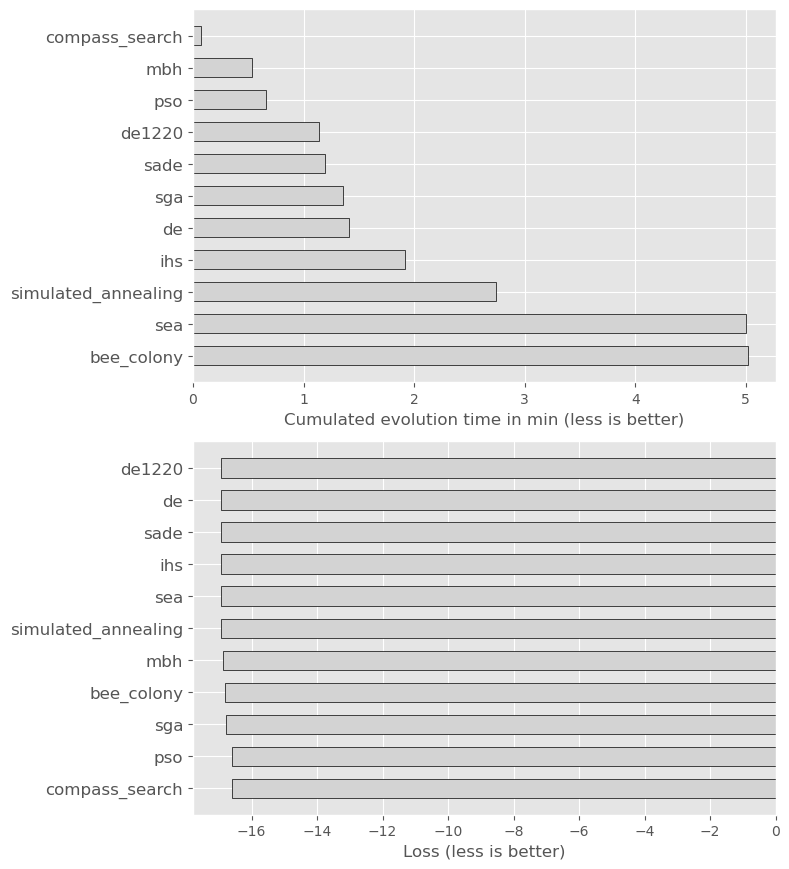

In [10]:
evotimes = [_result[1].evotime_trail[-1] for _result in results]
best_losses = [numpy.min(_result[1].losses_trail[-1]) for _result in results]

fig, ax = pyplot.subplots(nrows=2, ncols=1, dpi=100, figsize=(8, 0.8*len(optimizers)))
_t_sort = numpy.argsort(evotimes)
ax[0].barh(
    numpy.array(optimizers)[_t_sort], numpy.array(evotimes)[_t_sort], 
    facecolor='lightgrey', edgecolor='black', height=0.6,
)
ax[0].set_xlabel('Cumulated evolution time in min (less is better)', size=12)
ax[0].set_yticklabels(numpy.array(optimizers)[_t_sort], fontsize=12)
ax[0].invert_yaxis()

_loss_sort = numpy.argsort(best_losses)
ax[1].barh(
    numpy.array(optimizers)[_loss_sort], numpy.array(best_losses)[_loss_sort],  
    facecolor='lightgrey', edgecolor='black', height=0.6,
)
ax[1].set_yticklabels(numpy.array(optimizers)[_loss_sort], fontsize=12)
ax[1].set_xlabel('Loss (less is better)', size=12)
ax[1].invert_yaxis()
fig.tight_layout()

# Repeated evaluation of optimizer performance 

NOTE: This will take a considerable runtime since all optimizations (parameter estimation jobs) will be run several times

In [11]:
repeats = 5
repeated_evotimes = {_opt : [] for _opt in optimizers}
repeated_best_losses = {_opt : [] for _opt in optimizers}

_start = time.time()

for _repeat in range(repeats):
    print(f'\nRunning {_repeat+1} of {repeats} repeats.')
    for _optimizers in optimizers:
        print(f'    Optimizer: {_optimizers}')
        _result = run_estimation(_optimizers, max_evos, max_evotime, 0)
        repeated_evotimes[_optimizers].append(_result[1].evotime_trail[-1])
        repeated_best_losses[_optimizers].append(_result[1].best_loss_trail[-1])
        
print(f'\nComparison runtime was {(time.time() - _start)/60/60:.2f} h')


Running 1 of 5 repeats.
    Optimizer: de1220
    Optimizer: de
    Optimizer: sade
    Optimizer: ihs
    Optimizer: compass_search
    Optimizer: mbh
    Optimizer: simulated_annealing
    Optimizer: pso
    Optimizer: bee_colony
    Optimizer: sga
    Optimizer: sea

Running 2 of 5 repeats.
    Optimizer: de1220
    Optimizer: de
    Optimizer: sade
    Optimizer: ihs
    Optimizer: compass_search
    Optimizer: mbh
    Optimizer: simulated_annealing
    Optimizer: pso
    Optimizer: bee_colony
    Optimizer: sga
    Optimizer: sea

Running 3 of 5 repeats.
    Optimizer: de1220
    Optimizer: de
    Optimizer: sade
    Optimizer: ihs
    Optimizer: compass_search
    Optimizer: mbh
    Optimizer: simulated_annealing
    Optimizer: pso
    Optimizer: bee_colony
    Optimizer: sga
    Optimizer: sea

Running 4 of 5 repeats.
    Optimizer: de1220
    Optimizer: de
    Optimizer: sade
    Optimizer: ihs
    Optimizer: compass_search
    Optimizer: mbh
    Optimizer: simulated_annealing

## Visualize results

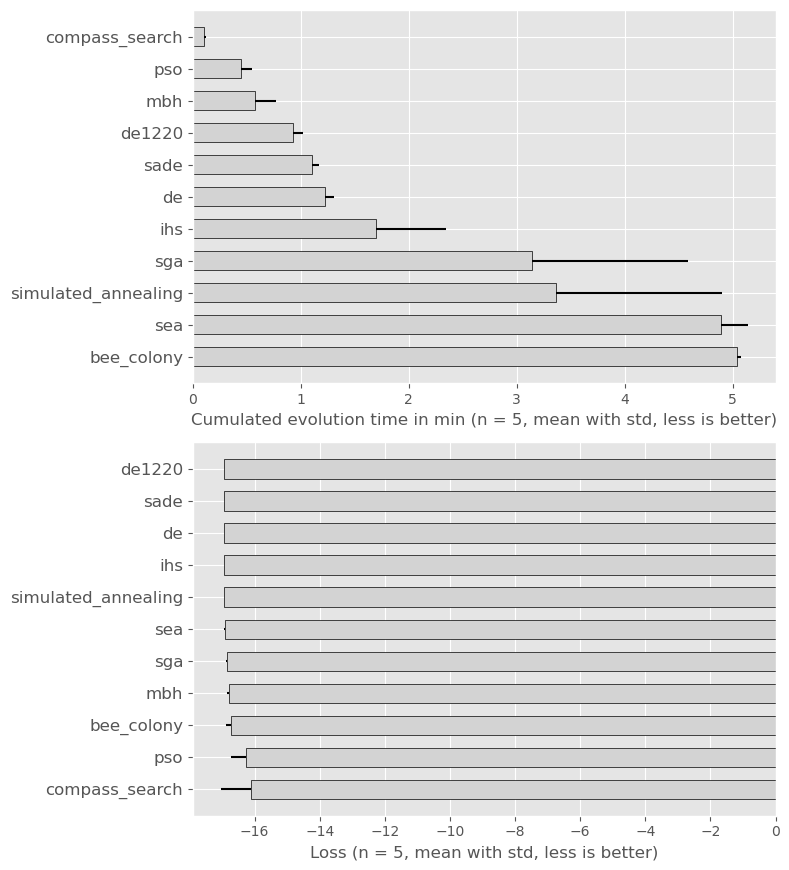

In [12]:
# Collect runtime results
_evotimes_means = {_p : numpy.mean(repeated_evotimes[_p]) for _p in repeated_evotimes}
_evotimes_std = {_p : numpy.std(repeated_evotimes[_p], ddof=1) for _p in repeated_evotimes}
_df_evotimes = pandas.DataFrame.from_dict([_evotimes_means, _evotimes_std]).T
_df_evotimes.columns = ['evotime_means', 'evotime_stds']
_df_evotimes.sort_values(by=['evotime_means'], ascending=False, inplace=True)
_df_evotimes

# Collect loss results
_losses_means = {_p : numpy.mean(repeated_best_losses[_p]) for _p in repeated_best_losses}
_losses_std = {_p : numpy.std(repeated_best_losses[_p], ddof=1) for _p in repeated_best_losses}
_df_losses = pandas.DataFrame.from_dict([_losses_means, _losses_std]).T
_df_losses.columns = ['losses_means', 'losses_stds']
_df_losses.sort_values(by=['losses_means'], ascending=False, inplace=True)

# Visualize results
fig, ax = pyplot.subplots(nrows=2, ncols=1, dpi=100, figsize=(8, 0.8*len(optimizers)))

# Show runtimes
ax[0].barh(
    _df_evotimes.index, 
    _df_evotimes['evotime_means'], 
    xerr=[numpy.zeros_like(_df_evotimes['evotime_stds']), _df_evotimes['evotime_stds']], 
    facecolor='lightgrey', edgecolor='black', height=0.6,
)
ax[0].set_xlabel(f'Cumulated evolution time in min (n = {repeats}, mean with std, less is better)', size=12)
ax[0].set_yticklabels(_df_evotimes.index, fontsize=12)

# Show losses
ax[1].barh(
    _df_losses.index, 
    _df_losses['losses_means'], 
    xerr=[_df_losses['losses_stds'], numpy.zeros_like(_df_losses['losses_stds'])], 
    facecolor='lightgrey', edgecolor='black', height=0.6,
)
ax[1].set_yticklabels(_df_losses.index, fontsize=12)
ax[1].set_xlabel(f'Loss (n = {repeats}, mean with std, less is better)', size=12)

fig.tight_layout()